# Introduzione

L'obiettivo è quello di utilizzare il dataset [Patient Survival Prediction](https://www.kaggle.com/datasets/mitishaagarwal/patient) per effettuare il training diversi classificatori, al fine di predirre se un paziente sopravvivrà o morirà sulla base dei *parametri vitali* registrati al momento dell'ingresso in ospedale. Per fare ciò si effettua innanzitutto una fase di **Data Exploration**, in modo da ricavare informazioni utili sui dati da utilizzare, e comprendere quali sono le feature probabilmente più rilevanti ai fini della classificazione. Dopo aver splittato il dataset in **Testing e Training Set**, si procede conj l'**Ingegneria delle Features** sul Training Set, rimuovendo le features con *valori nulli*, *poco correlate* con il target, ed applicando la *feature selection*. Successivamente si esegue una fase di **Model Selection** sui vari classificatori considerati, effettuando il *tuning dei loro iperparametri*. Infine, si eseguono tutti i **Classificatori** con le features ed i parametri individuati in precedenza, effettuando un confronto tra le prestazioni ottenute.

Il notebook è composto come segue:

- Operazioni Preliminari
    - Installazione dipendenze
    - Import delle Librerie
    - Caricamento del sataset
    - Funzioni e variabili user-defined

- Data Exploration
    - Descrizione del Dataset
    - Bilanciamento delle classi
    - Distribuzione delle Features
    - Visualizzazione campi non nulli
    - Conversione Features e Mapping
    - Correlazione tra le Features
    - Analisi delle Features
    
- Features Engineering
    - 
- Model Selection
- Classificazione
- Contronto e Conclusioni

# Operazioni Preliminari

Descriviamo le operazioni preliminari, necessarie per l'esecuzione delle varie celle nel notebook.

### Installazione Dipendenze

Prima di eseguire l'import delle librerie, è necessario che tutte queste siano installate sulla macchina locale. Per questo nel file `requirements` sono specificate tutte le dipendenze necessarie, facilmente installabili lanciando dalla directory del progetto il comando:

```
pip install -r requirements
```

### Import delle Librerie

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

import statsmodels.api as sm
import warnings
from sklearn.naive_bayes import BernoulliNB

### Caricamento del Dataset

Caricamento del dataset `csv` in `Dataframe` tramite `pandas`

In [ ]:
dataset = pd.read_csv("dataset/dataset.csv", sep=",")
dataset_bak = dataset
print(dataset.shape)
dataset.head()

### Funzioni e variabili user-defined

Effettuiamo la definizione di tutte le funzioni utilizzate nel notebook.

In [ ]:
global trainX                   # Righe del training set
global testX                    # Righe del testing set
global trainY                   # Colonna target del training set
global testY                    # Colonna target del testing set
global important_features       # Lista delle feature individuate nell'analisi preliminare
global correlation_matrix       # Matrice di correlazione tra le features

global trainX_og                # Mantiene una copia del training set originale, per il confronto delle prestazioni dopo la feature selection
global testX_og                 # Mantiene una copia del testing set originale, per il confronto delle prestazioni dopo la feature selection
global scores_dict              # Dizionario che mantiene tutti i risultati delle classificazioni effettuate

global scores_original          # Dataframe che mantiene i risultati della classificazioni sul dataset originale
global scores                   # Dataframe che mantiene i risultati delle classificazioni dopo la feature selection


important_features = []
scores_dict = {}

In [143]:
# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Rimuove le features columns_list specificate dal training set
# ---------------------------------------------------------------------------------------------------------------------------------------------------
def drop_features_from_trainset(columns_list):
    global trainX,testX
    trainX_tmp = trainX.copy()
    trainX = trainX.drop(columns=columns_list)
    testX = testX.drop(columns=columns_list)

    if (len(trainX_tmp.columns) - len(trainX.columns)) != 0:
        print ("Training Set Updated:",trainX_tmp.shape,"->",trainX.shape)
    else:
        print ("No features dropped!")
# ---------------------------------------------------------------------------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Ottiene la lista di features con correlazione rispetto al target inferiore alla threshold specificata
# ---------------------------------------------------------------------------------------------------------------------------------------------------
def get_low_correlated_features(threshold):
    td = []
    for feature in trainX.columns:
        ind = trainX.columns.get_loc(feature)
        target_corr = correlation_matrix.values[-1][ind]
        if (target_corr>=-threshold and target_corr<0) or (target_corr<=threshold and target_corr>0):
            td.append(feature)
    return td
# ---------------------------------------------------------------------------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Ottiene la percentuale di valori nulli per ogni feature del dataset, ritornando quelle colonne cui %NaN supera una certa threshold
# ---------------------------------------------------------------------------------------------------------------------------------------------------
def plot_nas(datasetX, use_threshold, threshold=None):
    to_delete = []
    if datasetX.isnull().sum().sum() != 0:
        na_datasetX = (datasetX.isnull().sum() / len(datasetX)) * 100
        na_datasetX = na_datasetX.drop(na_datasetX[na_datasetX == 0].index).sort_values(ascending=False)
        to_delete = na_datasetX[na_datasetX > threshold]

        missing_data = pd.DataFrame({'Null Ratio %' :na_datasetX})
        missing_data.plot(kind = "barh")
        plt.rcParams['figure.figsize'] = (20,20)

        if use_threshold:
            plt.axvline(x=threshold, color='red')
        plt.show()
        
    else:
        print('No NaNs found')
        return None
    
    if use_threshold:
        print(to_delete.index.tolist())
    return to_delete.index.tolist()
# ---------------------------------------------------------------------------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Mostra la matrice di confusione a seguito della classificazione
# ---------------------------------------------------------------------------------------------------------------------------------------------------
def show_confusion_matrix(cm,model_name):
    x_axis_labels = ["Dead", "Survived"]
    y_axis_labels = ["Dead", "Survived"]
    f, ax = plt.subplots(figsize =(7,7))
    sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Reds", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    plt.xlabel("PREDICTED LABEL")
    plt.ylabel("TRUE LABEL")
    plt.title('Confusion Matrix for {}'.format(model_name))
    plt.show()
# ---------------------------------------------------------------------------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Aggiunge i risultati di un classificatore al dizionario globale dei risultati.
# ---------------------------------------------------------------------------------------------------------------------------------------------------
def add_score(model_name,experiment,conf_matrix, report):
    TP,FN,FP,TN = conf_matrix.ravel()
    
    scores_dict[model_name] = {
        'Precision' : report['1']['precision'],
        'Accuracy' : report['accuracy'],

        'TPR (recall)': TP/(TP+FN),
        'FNR': FN/(TP+FN),   
        'TNR': TN/(TN+FP),
        'FPR': FP/(TN+FP),

        'experiment' : experiment
    }
# ---------------------------------------------------------------------------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Esegue i tre classificatori usati per il benchmark, oppure un modello specifico se indicato esplicitamente tra i parametri.
# ---------------------------------------------------------------------------------------------------------------------------------------------------
def run_classifications(tr_x,train_Y,te_x,test_Y,fill=None,model=None,model_name=None,experiment=None,show_report=False):
    train_X = tr_x.copy()
    test_X = te_x.copy()

    if fill:
        train_X = train_X.fillna(-1)
    
    test_X = test_X.fillna(-1)
    
    if model == None:
        lrc = LogisticRegression(solver="liblinear")
        rdt = DecisionTreeClassifier()
        gnb = GaussianNB()

        models = [(lrc, "Logistic Regression Classifier"),
                  (rdt, "Decision Tree Classifier"),
                  (gnb, "Gaussian Naive Bayes Classifier")]
    else:
        models = [(model,model_name)]

    for model in models:
        model[0].fit(train_X, train_Y)
        predicted = model[0].predict(test_X)
        report = classification_report(test_Y,predicted,output_dict=True)
        cm = confusion_matrix(test_Y, predicted, labels =[1, 0])
        add_score(model[1],experiment,cm,report)
        if show_report:
            report_print = classification_report(test_Y,predicted)
            print(model[1], "report: \n\n", report_print)
            show_confusion_matrix(cm,model[1])
# ---------------------------------------------------------------------------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Esegue la feature selection tramite Backward Regression, ritornando le colonne rimosse dalle features
# ---------------------------------------------------------------------------------------------------------------------------------------------------
def backward_regression(X, y, threshold_out=0.05):
    included = list(X.columns)
    recover = []
    removed = []
    
    while True:
        changed = False
        model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit(disp=False)
        pvalues = model.pvalues.iloc[1:]
        print (pvalues)
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if worst_feature not in important_features:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
                removed.append(worst_feature)
            else:
                recover.append(worst_feature)
        if not changed:
            break

    included.extend(recover)
    print(f"\nSelected Features:\n{included}")
    print(f"Removed Features:\n{removed}")
    return removed

# Data Exploration

Nella fase di data exploration andiamo ad analizzare il dataset a disposizione, cercando di ricavare informazioni utili e migliorare la conoscenza sul dominio di interesse.

## Descrizione del Dataset

Il dataset riporta parametri vitali di $91713$ pazienti al momento dell'ingresso in ospedale, come ad esempio peso, età, presenza di malattie gravi, o vari indici di [Apache Scoring](https://pubmed.ncbi.nlm.nih.gov/11579607/). Per ogni paziente, viene inoltre riportato se al termine del trattamento questo è sopravvissuto o deceduto. L'obiettivo dei classificatori allenati su questo dataset, è quindi quello di predirre in base ai parametri di un paziente se questo è in pericolo di vita oppure no.

La classe target è dunque ```hospital_death```, che è rappresentata con un valore binario:
- `0` se il paziente è sopravvissuto.
- `1` se il paziente è deceduto.

Si considera come **positivo** la classe `1`, in quanto si è più interessati a predirre se un paziente morirà . Considerando il dominio di interesse, si assume quindi che un *falso negativo sia un errore più grave rispetto ad un falso positivo*. Questo perché in uno scenario reale risulta molto più pericoloso sottostimare il problema (paziente grave, ma si predice che sopravvivrà), rispetto all'essere più pessimisti (paziente che sopravvive, ma si predice che non sopravvirà).

## Bilanciamento delle Classi

Vogliamo visualizzare il livello di bilanciamento del dataset rispetto alla classe target `hospital_death`. Utilizziamo quindi un `pieplot` per graficare il totale di istanze positive e negative

In [ ]:
classes = [{"Survived": (dataset["hospital_death"] == 0).sum(), "Dead": (dataset["hospital_death"] == 1).sum()}]
total  = pd.DataFrame(classes)
total_e = float(total["Survived"])
total_p = float(total["Dead"])
patients = [total_e, total_p]
patients_labels = 'Survived','Dead'
fig, ax = plt.subplots(figsize = (8,6))
plt.pie(patients,labels=patients_labels,autopct='%1.1f%%',colors = ['#88d14f', '#f23d3a'], explode=[0.05,0.05])
plt.title('Dataset Balancing', loc = "center", fontsize="20")
plt.axis('equal')
plt.legend(patients_labels,bbox_to_anchor=(0.6, -0.05, 0, 0))
fig.set_facecolor('white')
plt.show()

Come possiamo vedere il dataset è **altamente sbilanciato**. Infatti abbiamo il $91.4%$ di righe che riportano dati per un paziente sopravvissuto, mentre solo l'$8.6%$ di dati per un paziente deceduto. Ciò implica dire che qualsiasi modello allenato su tale dataset tenderà maggiormente a classificare un'istanza come `survived`, aspettandoci quindi un maggior numero di falsi negativi (`death` classificati erroneamente come `survived`).

Occorre osservare come tale sbilanciamento non è dovuto ad una scarsa qualità del dataset o mancanza di dati raccolti, ma intrinseco nella natura del problema analizzato; infatti considerando un insieme di ospedale è atteso che il numero di pazienti che sopravvivono sia di molto superiore al numero di decessi.

## Distribuzione delle Features

Andiamo a visualizzare la distribuzione delle features all'interno del dataset, riportando in un barplot le variabili categoriche e in un histplot le variabili numeriche.

In [ ]:
dataset.info()

In [ ]:
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
ignore = ['encounter_id','patient_id','Unnamed: 83','hospital_id','icu_id','hospital_death']
categ = []
numer = []

for col in dataset.drop(columns=ignore): 
    dt = dataset[col].dtype
    if dt == "object":
        categ.append(col)
    elif dt == "float64":
        if dataset[col].dropna().nunique()<10:
            dataset[col] = dataset[col].astype('object')
            categ.append(col)
        else:
            numer.append(col)
    elif dt == "int64":
        dataset[col] = dataset[col].astype('object')
        categ.append(col)

fig = plt.figure(figsize=(120,120))
j=1
a=0
b=0
for i in range(0, len(dataset.columns)-len(ignore)):
    col = dataset.columns[i]

    if col in categ:
        fig.add_subplot(10,10,j)
        ax = sns.countplot(x=categ[a], data=dataset, alpha=.7, order=sorted(dataset[col].dropna().unique().tolist(),key=str))
        ax.bar_label(ax.containers[0])
        ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
        j += 1
        a += 1

    elif col in numer:
        fig.add_subplot(10,10,j)
        sns.histplot(dataset[numer[b]].dropna(), kde_kws={"lw": 2, "color":colors[8]})
        j += 1
        b += 1

Possiamo osservare come la maggior parte delle variabili numeriche abbiano una distribuzione che tende ad una normale.

## Visualizzazione campi non nulli

Andiamo a visualizzare la percentuale di campi nulli presenti per ogni colonna *(feature)* del dataset. Questo risulta utile visualizzare eventuali colonne con pochi dati utili,e che possono quindi essere escluse ai fini del training

In [ ]:
p = plot_nas(dataset,use_threshold=False)

Analizzando la distribuzione delle varie features possiamo vedere come il dataset sia di buona qualità, avendo pochi campi non nulli nelle varie colonne. L'unica eccezione riguarda la feature ```Unnamed: 83```, che presenta esclusivamente campi nulli, e quindi verrà eliminata in una successiva fase di pulizia del dataset.

Le restanti features presentano valori `NaN` per una percentuale sempre inferiore al 20%, motivo per cui possiamo procedere con il *filling* o l'*imputazione* di tali dati, senza introdurre un rumore eccessivo nel dataset. 

## Conversione Features e Mapping

Si effettua la conversione delle features categoriche in ordinali, mappando ogni ```object``` identificato da una *stringa*, in un altro ```object``` identificato da un *numero*. Il dizionario ```mapping``` mantiene la corrispondenza tra label originale e numero assegnato, per un eventuale utilizzo futuro.

In [ ]:
mapped_dataset = dataset.copy()
encoder = LabelEncoder()
mapping = []

for i in range(len(mapped_dataset.columns)):
    
    if (mapped_dataset[mapped_dataset.columns[i]].dtype == "object"):
            mapped_dataset[mapped_dataset.columns[i]] = encoder.fit_transform(mapped_dataset[mapped_dataset.columns[i]])
            mapping_dict = {index : label for index , label in enumerate(encoder.classes_)}
            mapping.append(mapping_dict)

mapped_dataset = mapped_dataset.where(~dataset.isna(), dataset)


Visualizziamo il mapping effettuato delle variabili categoriche.

- *NOTA*: I valori `NaN` risultano mappati nel dizionario, ma tramite la clausola `where(~dataset.isna(), dataset)` vengono ristabiliti i valori `NaN` presenti nel dataset originale, per la successiva fase di imputazione dei dati.

In [ ]:
print(mapping)

Completiamo il mapping del dataset trasformando il tipo di dato associato alle features categoriche dall' `object` numerico al valore `float64` ad esso associato, in quanto i vari classificatori operano comunque con valori numerici.

In [ ]:
for el in mapped_dataset.columns:
    if (mapped_dataset[el].dtype == "object"):
        mapped_dataset[el] = np.floor(pd.to_numeric(mapped_dataset[el], errors='coerce')).astype('float64')

Vediamo che abbiamo mappato le nostre variabili categoriche in variabili numeriche. I valori nulli sono stati mantenuti <NaN> per una successiva fase di imputazione. 

In [ ]:
mapped_dataset.info()

## Correlazione tra le Features

Analizziamo il grado di correlazione reciproco tra le varie feature, compresa la correlazione di ogni feature con il target. In generale vogliamo che una feature sia **altamente correlata** con il target (quindi che il suo valore sia importante per discriminare se il paziente sopravvive o muore). Si utilizza a tale scopo l'indice di Pearson, in cui si ha un valore compreso tra $(-1,+1)$:
- $-1$ corrisponde alla perfetta correlazione lineare positiva.
- $0$ corrisponde a un'assenza di correlazione lineare.
- $-1$ corrisponde alla perfetta correlazione lineare negativa.

In [ ]:
correlation_matrix = mapped_dataset.drop(columns="Unnamed: 83").corr()

Mostriamo la matrice di correlazione

In [ ]:
plt.figure(figsize=(32,24), dpi = 250)
sns.heatmap(correlation_matrix, linewidths=0.05, cmap="PiYG", annot=True, annot_kws={"fontsize":4})
plt.yticks(rotation=0)
plt.show()

## Analisi delle Features

Analizziamo l'impatto di alcune features rispetto al valore del target. In questo modo dall'analisi del dominio si possono individuare le features che risultano rilevanti ai fini della classificazione, e che vogliamo necessariamente mantenere anche a seguito della riduzione della dimensionalità.

### Probabilità di morte in relazione all'età

Visualizziamo la probabilità di decesso in relazione all'età dei pazienti, distinguendo due casi in base al genere `maschio` o `femmina`

In [ ]:
warnings.filterwarnings('ignore')

age_death_F=dataset[dataset['gender']=='F'][['age','hospital_death']].groupby('age').mean().reset_index()
age_death_M=dataset[dataset['gender']=='M'][['age','hospital_death']].groupby('age').mean().reset_index()
fig,ax = plt.subplots(figsize = (12,8))
sns.lineplot(x=age_death_F['age'], y=age_death_F['hospital_death'])
sns.lineplot(x=age_death_M['age'], y=age_death_M['hospital_death'])
plt.title("Average hospital death probability of patients", fontsize = 20)

plt.legend(['Female',"Male"])
plt.xlabel("Patient Age")
plt.ylabel("Average Hospital Death")
fig.show()

warnings.filterwarnings('always')

Come atteso, l'età risulta essere un fattore determinante nella mortalità dei pazienti ricoverati, ed infatti si può notare un incremento della mortalità con l'avanzare dell'età. Inoltre si può anche osservare come il genere non risulta rilevante nella probabilità di morte, in quanti maschi e femmine hanno circa lo stesso andamento in relazione all'età.

In [ ]:
important_features.append('age')

### Probabilità di morte in relazione all'etnia

Vogliamo verificare se l'etnia di un paziente ha un impatto sulla probabilità di morte.

In [ ]:
warnings.filterwarnings('ignore')

df=dataset[['hospital_death','ethnicity']]

ethnicity_death=df[['ethnicity','hospital_death']].groupby('ethnicity').mean().reset_index()
fig,ax = plt.subplots(figsize = (12,8))
sns.barplot(x=ethnicity_death['ethnicity'], y=ethnicity_death['hospital_death'])
plt.title("Impacts of Ethnicity over patients", fontsize = 20)

plt.xlabel("ethnicity")
plt.ylabel("Average Hospital Death")
fig.show()

warnings.filterwarnings('always')

Come possiamo vedere la probabilità di morte risulta simile tra tutte le etnie. La feature `ethnicity` non è quindi da considerarsi importante ai fini della classificazione, e verrà ulteriormente analizzata nella fase di *feature Engineering*.

### Probabilità di morte in relazione al BMI

Vogliamo visualizzare l'impatto dell'*Indice di Massa Corporea* sulla probabilità dei pazienti. 

In [ ]:
warnings.filterwarnings('ignore')

df=dataset[['hospital_death','bmi']]

df['bmi'] = df['bmi'].round(0)
bmi_death=df[['bmi','hospital_death']].groupby('bmi').mean().reset_index()
fig,ax = plt.subplots(figsize = (12,8))
sns.lineplot(x=bmi_death['bmi'], y=bmi_death['hospital_death'])
plt.title("Impacts of BMI over patients", fontsize = 20)

plt.xlabel("BMI")
plt.ylabel("Average Hospital Death")
fig.show()

warnings.filterwarnings('always')

Il BMI impatta notevolmente nella mortalità, infatti un valore troppo basso ($<20$, gravemente sottopeso) o troppo alto ($>50$, obesità di terzo grado) aumenta la probabilità di decesso.  

In [ ]:
important_features.append('bmi')

### Probabilità di morte in relazione a score apache

Gli score apache misurano parametri vitali critici, quindi che discriminano fortemente la probabilità di sopravvivenza di un paziente. Andiamo a graficare quindi l'impatto di tali indici sulla probabilità di decesso.

In [ ]:
warnings.filterwarnings('ignore')


critical = ['hospital_death','gcs_eyes_apache','gcs_motor_apache','gcs_unable_apache','gcs_verbal_apache','apache_3j_bodysystem','apache_2_bodysystem']
df=dataset[critical]

gcs_eyes_apache_death=df[['gcs_eyes_apache','hospital_death']].groupby('gcs_eyes_apache').mean().reset_index()
gcs_motor_apache_death=df[['gcs_motor_apache','hospital_death']].groupby('gcs_motor_apache').mean().reset_index()
gcs_unable_apache_death=df[['gcs_unable_apache','hospital_death']].groupby('gcs_unable_apache').mean().reset_index()
gcs_verbal_apache_death=df[['gcs_verbal_apache','hospital_death']].groupby('gcs_verbal_apache').mean().reset_index()
apache_3j_bodysystem_death=df[['apache_3j_bodysystem','hospital_death']].groupby('apache_3j_bodysystem').mean().reset_index()
apache_2_bodysystem_death=df[['apache_2_bodysystem','hospital_death']].groupby('apache_2_bodysystem').mean().reset_index()


fig = plt.figure(figsize=(30,15))

fig.add_subplot(2,3,1)
sns.barplot(x=gcs_eyes_apache_death['gcs_eyes_apache'], y=gcs_eyes_apache_death['hospital_death'])
plt.title("Impacts of GCS Eyes over Patients", fontsize = 20)
plt.xlabel("GCS Eyes")
plt.ylabel("Average Hospital Death")

fig.add_subplot(2,3,2)
sns.barplot(x=gcs_motor_apache_death['gcs_motor_apache'], y=gcs_motor_apache_death['hospital_death'])
plt.title("Impacts of GCS Motor over Patients", fontsize = 20)
plt.xlabel("GCS Motor")
plt.ylabel("Average Hospital Death")

fig.add_subplot(2,3,3)
sns.barplot(x=gcs_unable_apache_death['gcs_unable_apache'], y=gcs_unable_apache_death['hospital_death'])
plt.title("Impacts of GCS Unable over Patients", fontsize = 20)
plt.xlabel("GCS Unable")
plt.ylabel("Average Hospital Death")

fig.add_subplot(2,3,4)
sns.barplot(x=gcs_verbal_apache_death['gcs_verbal_apache'], y=gcs_verbal_apache_death['hospital_death'])
plt.title("Impacts of GCS Verbal over Patients", fontsize = 20)
plt.xlabel("Hepatitic Failure")
plt.ylabel("Average Hospital Death")

fig.add_subplot(2,3,5)
ax = sns.barplot(x=apache_3j_bodysystem_death['apache_3j_bodysystem'], y=apache_3j_bodysystem_death['hospital_death'])
plt.title("Impacts of Apache III over Patients", fontsize = 20)
plt.xlabel("3J Bodysystem")
plt.ylabel("Average Hospital Death")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

fig.add_subplot(2,3,6)
ax = sns.barplot(x=apache_2_bodysystem_death['apache_2_bodysystem'], y=apache_2_bodysystem_death['hospital_death'])
plt.title("Impacts of Apache II over Patients", fontsize = 20)
plt.xlabel("2 Bodysystem")
plt.ylabel("Average Hospital Death")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

fig.show()

warnings.filterwarnings('always')

Vediamo come nel caso degli score GCS, per gli score critici (valori più bassi) si hanno sempre probabilità più alte di decesso. Invece per gli indici di Bodysystem possiamo vedere come diagnosi differenti abbiano probabilità di decesso differenti. Ad esempio la setticemia o complicanze respiratorie sono più critiche rispetto a casi ginecologici o metabolici.

Questo ci indica dunque come gli score Apache risultano critici ai fini della classificazione.

In [ ]:
important_features.extend(['gcs_eyes_apache','gcs_motor_apache','gcs_unable_apache','gcs_verbal_apache','apache_3j_bodysystem','apache_2_bodysystem'])

### Probabilità di morte in relazione a malattie critiche

Visualizziamo l'impatto di differenti malattie critiche rispetto alla probabilità di decesso di un paziente.

In [ ]:
warnings.filterwarnings('ignore')


critical = ['hospital_death','aids','cirrhosis','diabetes_mellitus','hepatic_failure','immunosuppression','leukemia','lymphoma','solid_tumor_with_metastasis']
df=dataset[critical]

aids_death=df[['aids','hospital_death']].groupby('aids').mean().reset_index()
cirrhosis_death=df[['cirrhosis','hospital_death']].groupby('cirrhosis').mean().reset_index()
diabetes_mellitus_death=df[['diabetes_mellitus','hospital_death']].groupby('diabetes_mellitus').mean().reset_index()
hepatic_failure_death=df[['hepatic_failure','hospital_death']].groupby('hepatic_failure').mean().reset_index()
immunosuppression_death=df[['immunosuppression','hospital_death']].groupby('immunosuppression').mean().reset_index()
leukemia_death=df[['leukemia','hospital_death']].groupby('leukemia').mean().reset_index()
lymphoma_death=df[['lymphoma','hospital_death']].groupby('lymphoma').mean().reset_index()
solid_tumor_death=df[['solid_tumor_with_metastasis','hospital_death']].groupby('solid_tumor_with_metastasis').mean().reset_index()

fig = plt.figure(figsize=(30,20))

fig.add_subplot(3,3,1)
sns.barplot(x=aids_death['aids'], y=aids_death['hospital_death'])
plt.title("Impacts of AIDS over Patients", fontsize = 20)
plt.xlabel("AIDS")
plt.ylabel("Average Hospital Death")

fig.add_subplot(3,3,2)
sns.barplot(x=cirrhosis_death['cirrhosis'], y=cirrhosis_death['hospital_death'])
plt.title("Impacts of Cirrhosis over Patients", fontsize = 20)
plt.xlabel("Cirrhosis")
plt.ylabel("Average Hospital Death")

fig.add_subplot(3,3,3)
sns.barplot(x=diabetes_mellitus_death['diabetes_mellitus'], y=diabetes_mellitus_death['hospital_death'])
plt.title("Impacts of Diabetes Mellitus over Patients", fontsize = 20)
plt.xlabel("Diabetes Mellitus")
plt.ylabel("Average Hospital Death")

fig.add_subplot(3,3,4)
sns.barplot(x=hepatic_failure_death['hepatic_failure'], y=hepatic_failure_death['hospital_death'])
plt.title("Impacts of Hepatitic Failure over Patients", fontsize = 20)
plt.xlabel("Hepatitic Failure")
plt.ylabel("Average Hospital Death")

fig.add_subplot(3,3,5)
sns.barplot(x=immunosuppression_death['immunosuppression'], y=immunosuppression_death['hospital_death'])
plt.title("Impacts of Immunosuppression over Patients", fontsize = 20)
plt.xlabel("Immunosuppression")
plt.ylabel("Average Hospital Death")

fig.add_subplot(3,3,6)
sns.barplot(x=leukemia_death['leukemia'], y=leukemia_death['hospital_death'])
plt.title("Impacts of Leukemia over Patients", fontsize = 20)
plt.xlabel("Lekuemia")
plt.ylabel("Average Hospital Death")

fig.add_subplot(3,3,7)
sns.barplot(x=lymphoma_death['lymphoma'], y=lymphoma_death['hospital_death'])
plt.title("Impacts of Lymphoma over Patients", fontsize = 20)
plt.xlabel("Lypmhoma")
plt.ylabel("Average Hospital Death")

fig.add_subplot(3,3,8)
sns.barplot(x=solid_tumor_death['solid_tumor_with_metastasis'], y=solid_tumor_death['hospital_death'])
plt.title("Impacts of Solid Tumor with Metastasis over Patients", fontsize = 20)
plt.xlabel("Solid Tumor with Metastasis")
plt.ylabel("Average Hospital Death")

fig.show()

warnings.filterwarnings('always')

Vediamo come tutte queste variabili risultano importanti, in quanto incrementano la probabilità di decesso. L'unica eccezione è il diabete, che risulta non impattare nella probabilità di decesso (bassa in entrambi i casi)

In [ ]:
important_features.extend(['aids','cirrhosis','hepatic_failure','immunosuppression','leukemia','lymphoma','solid_tumor_with_metastasis'])

### Altre condizioni di ricovero

Verifichiamo altre condizioni sul paziente, in particolare se questo è intubato, presenta iperventilazione, oppure si è operato da poco

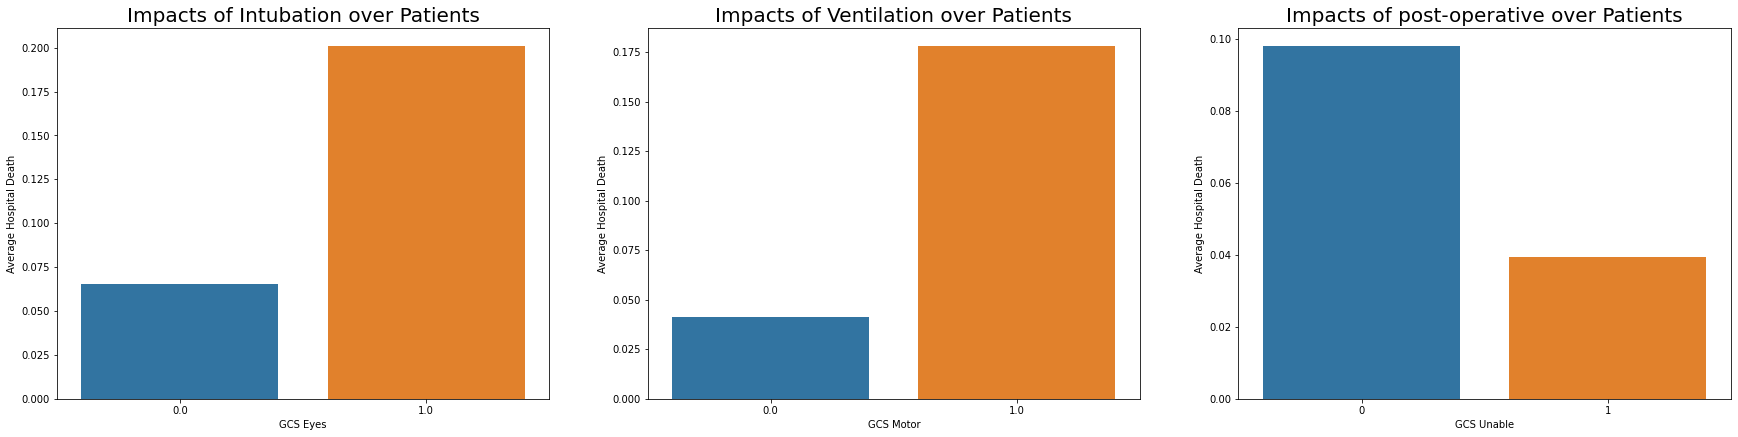

In [156]:
warnings.filterwarnings('ignore')

critical = ['hospital_death','intubated_apache', 'ventilated_apache', 'apache_post_operative']
df=dataset[critical]

intubated_apache_death=df[['intubated_apache','hospital_death']].groupby('intubated_apache').mean().reset_index()
ventilated_apache_death=df[['ventilated_apache','hospital_death']].groupby('ventilated_apache').mean().reset_index()
apache_post_operative_death=df[['apache_post_operative','hospital_death']].groupby('apache_post_operative').mean().reset_index()



fig = plt.figure(figsize=(30,15))

fig.add_subplot(2,3,1)
sns.barplot(x=intubated_apache_death['intubated_apache'], y=intubated_apache_death['hospital_death'])
plt.title("Impacts of Intubation over Patients", fontsize = 20)
plt.xlabel("GCS Eyes")
plt.ylabel("Average Hospital Death")

fig.add_subplot(2,3,2)
sns.barplot(x=ventilated_apache_death['ventilated_apache'], y=ventilated_apache_death['hospital_death'])
plt.title("Impacts of Ventilation over Patients", fontsize = 20)
plt.xlabel("GCS Motor")
plt.ylabel("Average Hospital Death")

fig.add_subplot(2,3,3)
sns.barplot(x=apache_post_operative_death['apache_post_operative'], y=apache_post_operative_death['hospital_death'])
plt.title("Impacts of post-operative over Patients", fontsize = 20)
plt.xlabel("GCS Unable")
plt.ylabel("Average Hospital Death")

fig.show()

warnings.filterwarnings('always')

Si osserva come `intubated_apache` e `ventilated_apache` aumentano significativamente la probabilità di decesso, e sono dunque da considerarsi features importanti. Al contrario riguardo `apache_post_operative` un paziente operato sembra avere una probabilità di decesso leggermente inferiore, per cui non viene considerata tra le feature importanti.  

In [160]:
important_features.extend(['intubated_apache','ventilated_apache'])

### Hospital Quality

Vediamo se diverse strutture ospedaliere hanno maggiore o minore impatto sulla mortalità dei pazienti

In [ ]:
fig2 = plt.figure(figsize=(35,35))
hospital_death=dataset[['hospital_id','hospital_death']].groupby('hospital_id').mean().reset_index()
sns.barplot(x=hospital_death['hospital_id'], y=hospital_death['hospital_death'])
plt.title("Impacts of Hospital over Patients", fontsize = 20)
plt.xlabel("Hospital")
plt.ylabel("Average Hospital Death")
plt.tick_params(labelsize = 8)

plt.show()

Osserviamo che alcuni ospedali sembrano avere probabilità di decesso elevate. Ad esempio l'ospedale ```131``` ha il 50% di decessi. Analizzando però il dataset possiamo vedere come in realtà ci siano soltanto due istanze relative all'ospedale 130, che è quindi un outlier.

In [ ]:
dataset['hospital_id'].value_counts()[130]

Anche l'ospedale ```51``` ha una probabilità più alta di decesso. Ma anche in questo caso possiamo vedere come siano pochi i dati (110) rispetto agli altri ospedali

In [ ]:
dataset['hospital_id'].value_counts()[51]

Anche la feature `hospital` non è quindi da considerarsi importante ai fini della classificazione, e verrà ulteriormente analizzata nella fase di *feature Engineering*.

### Features Individuate

In definitiva sono ritenute di particolare interesse nella classificazione le seguenti features

In [ ]:
important_features

# Criterio di Performance Evaluation

Prima di procedere con l'ingegneria delle features è necessario definire un criterio per valutare la "bontà" di una modifica effettuata. A tale scopo, si misurano le prestazioni di tre classificatori differenti sul training set originale, e si confrontano con gli score a seguito della *Feature Engineering*. In questo modo alcuni tra i possibili approcci di *dimensionality reduction* non sono stati poi applicati, in quanto non portavano effettive migliorie sul modello (*par. "Altri tentativi di miglioramento"*.

## Training & Test Set Splitting

Andiamo a splittare il dataset in training e stesting set. Utilizziamo come percentuali $80/20$ sul dataset originale

In [ ]:
targets = mapped_dataset['hospital_death']
trainX, testX, trainY, testY = train_test_split(mapped_dataset.drop(columns = 'hospital_death'), targets, test_size = 0.2, random_state=0)
print("TrainingSet:",trainX.shape)
print("TestingSet:",testX.shape)

trainX_og = trainX.copy()
testX_og = testX.copy()

## Scelta della Metrica

Come spiegato nella Descrizione del Dataset, si è maggiormente interessati ad **evitare i falsi negativi**, ovvero istanze predete come `survived` ma che sono in realtà `death`. Di conseguenza, la principale metrica considerata per valutare le prestazioni dei vari modelli è la <b>recall</b>: $$Recall = \frac{TP}{TP + FN}$$

Tuttavia, si deve tener conto anche dei **FP**, valutando un tradeoff tra i due indici per evitare un aumento eccessivo degli errori di classificazione sui pazienti `survived`.

## Risultati sul Dataset Originale

Andiamo a misurare le prestazioni di vari classificatori sul dataset originale, quindi senza ingegneria delle features e imputazione dei valori mancanti. 
- I classificatori considerati non gestiscono in modo automatico i valori ```NaN```
- Per eseguire la classificazione è comunque necessario mappare i valori ```NaN``` su un qualche valore numerico
- Si utilizza per questa fase di benchmark l'operatore ```fillna(-1)``` sostituendo quindi ```NaN``` con ```-1```

In [ ]:
run_classifications(trainX,trainY,testX,testY, fill = True, experiment="Original Dataset")
scores = pd.DataFrame(scores_dict).T
original_scores = scores.copy()
original_scores

# Feature Engineering

Andiamo ad eseguire diverse operazioni per ridurre la dimensionalità del dataset, rimuovendo quelle features non rilevanti ai fini della classificazione.
- Rimozione feature con valori nulli
- Rimozione feature con bassa varianza dei dati
- Rimozione feature con bassa correlazione con il target 
- Feature Selection
- Altri tentativi di miglioramento

## Rimozione feature con valori nulli

Rimuoviamo quelle colonne il cui valore percentuale di colonne nulle supera l'80%, e su cui risulterebbe inutile l'imputazione dei dati mancanti.

In [ ]:
features_to_remove = plot_nas(trainX,use_threshold=True,threshold=80)

Soltanto la feature `Unnamed: 83` supera la soglia prefissata, per cui la rimuoviamo dal dataset

In [ ]:
drop_features_from_trainset(features_to_remove)

## Rimozione features con bassa varianza

Otteniamo la lista delle feature che presentano una varianza minore ad 0.01

In [ ]:
warnings.filterwarnings('ignore')

original_cols = trainX_og.columns
threshold = 0.01

selector = VarianceThreshold(threshold)
selector.fit(trainX)
features_to_remove = [x for x in trainX.columns if x not in selector.get_feature_names_out()]
print("Features to remove:",features_to_remove)

warnings.filterwarnings('always')

Anche se poco variabili, 'gcs_unable_apache', 'aids', 'apache_2_bodysystem', 'lymphoma' sono importanti come visto nell'analisi delle feature quindi non andiamo a rimuoverle

Non viene rimossa nessuna feature dal training set

In [ ]:
features_to_remove = list(set(features_to_remove) - set(important_features))
drop_features_from_trainset(features_to_remove)

## Rimozione features con bassa correlazione col target

Ricaviamo le features che hanno una bassa correlazione con il target, inferiore ad una threshold di 0.03

In [ ]:
features_to_remove = get_low_correlated_features(0.03)
print(features_to_remove)

Di queste variabili aids, leukemia e lymphoma sono comunque importanti nel dominio quindi non le andiamo a rimuovere

In [ ]:
to_delete = list(set(features_to_remove) - set(important_features))
print(to_delete)

Rimuoviamo le feature individuate dal dataset

In [ ]:
drop_features_from_trainset(to_delete)

## Feature Selection

Si utilizza la **Backward Stepwise Feature Selection** come ulteriore tecnica per la riduzione della dimensionalità. Questa viene eseguita a partire dal sottoinsieme di feature individuate dopo aver applicato le tecniche precedentemente descritte.

In [144]:
features_to_remove = backward_regression(trainX.fillna(-1),trainY)

<class 'statsmodels.discrete.discrete_model.BinaryResultsWrapper'>
age                              5.418901e-25
bmi                              5.790811e-05
elective_surgery                 1.309128e-19
pre_icu_los_days                 1.974177e-21
weight                           7.094229e-01
apache_2_diagnosis               1.836414e-03
apache_3j_diagnosis              6.851546e-13
apache_post_operative            2.290984e-06
gcs_eyes_apache                  4.473565e-03
gcs_motor_apache                 1.310607e-29
gcs_unable_apache                3.805088e-11
gcs_verbal_apache                7.442661e-03
heart_rate_apache                3.697269e-04
intubated_apache                 3.591679e-02
map_apache                       2.022376e-01
resprate_apache                  3.161625e-13
temp_apache                      1.235886e-08
ventilated_apache                7.683532e-81
d1_diasbp_min                    2.095454e-01
d1_diasbp_noninvasive_min        6.479827e-01
d1_heartrate_

Rimuoviamo dal training set le feature non selezionate

In [ ]:
drop_features_from_trainset(features_to_remove)

In [146]:
from sklearn.feature_selection import RFE
selector = RFE(estimator = DecisionTreeClassifier() ,step=1)
selector = selector.fit(trainX.fillna(-1), trainY.fillna(-1))
rfe_mask = selector.get_support() #list of booleans for selected features
new_features = [] 
for bool, feature in zip(rfe_mask, trainX.columns):
    if bool:
        new_features.append(feature)

new_features # The list of your 5 best features

['age',
 'bmi',
 'pre_icu_los_days',
 'weight',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'heart_rate_apache',
 'map_apache',
 'resprate_apache',
 'temp_apache',
 'd1_diasbp_min',
 'd1_heartrate_max',
 'd1_mbp_min',
 'd1_resprate_max',
 'd1_spo2_min',
 'd1_sysbp_min',
 'd1_sysbp_noninvasive_min',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_sysbp_max',
 'h1_sysbp_noninvasive_min',
 'd1_glucose_max',
 'd1_potassium_max',
 'apache_4a_hospital_death_prob',
 'apache_4a_icu_death_prob']

In [163]:
not_selected = list(set(trainX.columns) - set(new_features))
features_to_remove = list(set(not_selected) - set(important_features))

In [164]:
drop_features_from_trainset(features_to_remove)

Training Set Updated: (73370, 59) -> (73370, 44)


Vediamo che al termine della fase di pulizia abbiamo ridotto notevolmente la dimensionalità del dataset, passando da 84 a 44 features

## Confronto Prestazioni

Confrontiamo le prestazioni ottenute nel training set originale con quelle a seguito della *dimensionality reduction*.

In [ ]:
original_scores

In [ ]:
run_classifications(trainX,trainY,testX,testY, fill = True, experiment="Feature Engineering")
scores = pd.DataFrame(scores_dict).T
scores

Vediamo inoltre che mantenendo le **feature importanti** individuate nella fase di analisi, si hanno prestazioni sensibilmente migliori nel classificare le classi `death` rispetto al rimuoverle nel filtraggio automatico con varianza, correlazione e feature selection. In particolare si hanno delle classificazioni migliori in relazione alle classi `death`

## Altri tentativi di Miglioramento

Analizziamo ulteriori tecniche applicate per migliorare la qualità del dataset.

### Data Imputation

Si utilizza un meccanismo di imputazione per sopperire alla presenza di dati mancanti delle diverse features del dataset. L'obiettivo è quello di ripristinare le diverse variabili per l'uso nella classificazione rimpiazzando tutti i dati nulli con valori derivati da entry simili nel dataset.

In [ ]:
imp = KNNImputer(n_neighbors=1, weights='uniform')
trainX_imp = pd.DataFrame(imp.fit_transform(trainX), columns = trainX.columns)

Analizziamo i risultati a seguito della data imputation

In [ ]:
run_classifications(trainX_imp,trainY,testX,testY, fill = False)
scores = pd.DataFrame(scores_dict).T
scores

Osserviamo che tutti gli score peggiorano. Questo perché si introduce comunque rumore nel dataset, e bisogna considerare che un valore assente potrebbe avere comunque un significato, e potrebbe esse in alcuni casi errato andarlo a rimpiazzare. Utilizzando invece `fillna(-1)` si mantengono i `NaN` semplicemente mappandoli a `-1`, valore esclusivo non usato per altre variabili nel dizionario. 

Possiamo quindi in definitiva mappare a -1 tutti i valori `NaN` nel training set e testing set. Si noti che la modifica nel testing set non rappresenta una manipolazione dei dati, ma soltanto come questi vengono codificati in fase di lettura.

In [ ]:
trainX = trainX.fillna(-1)
testX = testX.fillna(-1)

### PCA: Principal Component Analysis

Cerchiamo di ridurre ulteriormente la dimensionalità del dataset applicando la Principal Component Analysis.

In [ ]:
print(trainX.shape)
pca = PCA(n_components=int(trainX.shape[1]*0.7))
trainX_pca = pd.DataFrame(pca.fit_transform(trainX))
testX_pca = pd.DataFrame(pca.transform(testX))
print(trainX_pca.shape)

Analizziamo i risultati a seguito di PCA

In [ ]:
scores

In [ ]:
run_classifications(trainX_pca,trainY,testX_pca,testY, experiment="PCA after FE")
scores_pca = pd.DataFrame(scores_dict).T
scores_pca

I risultati risultano inferiori a seguito dell'applicazione di PCA sull'ultimo insieme di features individuate. Proviamo anche ad applicare PCA sull'insieme originale di features, per verificare se questo operi meglio rispetto al processo di selezione applicato. Anche in questo caso vengono generate 32 features sintetiche. Possiamo però osservare come i risultati siano addirittura peggiori rispetto al caso precedente

In [ ]:
print(trainX_og.shape)
pca = PCA(n_components=int(trainX.shape[1]*0.7))
trainX_pca = pd.DataFrame(pca.fit_transform(trainX_og.fillna(-1)))
testX_pca = pd.DataFrame(pca.transform(testX_og.fillna(-1)))
print(trainX_pca.shape)

run_classifications(trainX_pca,trainY,testX_pca,testY,experiment="PCA without FE")
scores_pca = pd.DataFrame(scores_dict).T
scores_pca

In definitiva non viene applicata PCA in quanto si hanno risultati migliori applicando soltanto l'ingegneria delle features descritta in precedenza.

### Sampling

Come visto nella Data Exploration il dataset risulta fortemente sbilanciato. Anche a seguito dello splitting in training e testing set resta tale sbilanciamento.

In [ ]:
classes = [{"Survived": (trainY== 0).sum(), "Dead": (trainY== 1).sum()}]
total  = pd.DataFrame(classes)
total_e = float(total["Survived"])
total_p = float(total["Dead"])
mushrooms = [total_e, total_p]
mushrooms_labels = 'Survived','Dead'
fig, ax = plt.subplots(figsize = (8,6))
plt.pie(mushrooms,labels=mushrooms,autopct='%1.1f%%',colors = ['#88d14f', '#f23d3a'])
plt.title('Dataset Balancing', loc = "center", fontsize="20")
plt.axis('equal')
plt.legend(mushrooms_labels,bbox_to_anchor=(0.6, -0.05, 0, 0))
fig.set_facecolor('white')
plt.show()

Questo, come già visto nell'analisi preliminare porta il modello a classificare più frequentemente le classi come `survived`, in quanto ha molti più dati in percentuale su cui effettuare il training. Per questo si possono applicare diverse strategie per cercare di ripristinare il bilanciamento del dataset:

- Undersampling
- Oversampling
- SMOTE

#### Undersampling

In [ ]:
num_survd = (trainY== 0).sum()
num_death = (trainY== 1).sum()

num_under = num_survd - num_death
print ("Removing",num_under,"istances")

rus = RandomUnderSampler(random_state=0)
trainX_und,trainY_und = rus.fit_resample(trainX_og.fillna(-1),trainY.fillna(-1))

Vediamo dai risultati che peggiorano tutte le metriche applicando il balancing.

In [ ]:
scores

In [ ]:
run_classifications(trainX_und,trainY_und,testX_og,testY,experiment="undersampling")
scores_und = pd.DataFrame(scores_dict).T
scores_und

Come atteso migliorano effettivamente le classificazioni di classi `death` rispetto a `survived`. Tuttavia rimuovendo $60882$ istanze dal training set si ha una significativa perdita di informazioni, che porta l'**accuracy** del modello a decrescere significativamente. Inoltre possiamo vedere all'aumento della recall corrisponda un abbassamento della precision, indice del fatto che il classificatore tende semplicemente a classificare più istanze come positive (aumentano i falsi negativi).

#### Oversampling

In [ ]:
num_survd = (trainY== 0).sum()
num_death = (trainY== 1).sum()

num_under = num_survd - num_death
print ("Creating",num_under,"istances")

ros = RandomOverSampler(random_state=0)
trainX_ov,trainY_ov = ros.fit_resample(trainX_og.fillna(-1),trainY.fillna(-1))

In [ ]:
run_classifications(trainX_ov,trainY_ov,testX_og,testY,experiment="oversampling")

In [ ]:
scores

In [ ]:
scores_ov = pd.DataFrame(scores_dict).T
scores_ov

#### SMOTE

In [ ]:
smote = SMOTE(random_state=0)
trainX_smote, trainY_smote = smote.fit_resample(trainX.fillna(-1), trainY)

run_classifications(trainX_smote,trainY_smote,testX,testY,fill=True,experiment="SMOTE")

In [ ]:
scores

In [ ]:
scores_smote = pd.DataFrame(scores_dict).T
scores_smote

Tra tutti i metodi di sampling **SMOTE** è quello che fornisce risultati migliori, andando a creare istanze artificiali comunque simili a quelle già presenti. Come possiamo osservare, applicando il sampling si nota effettivamente un miglioramento nella classificazione delle classi `death`.

Tuttavia è necessario considerare vengono inserite $\frac{6}{7}$ di istanze artificiali. Lo sbilanciamento del dataset in questo caso risulta troppo elevato per poter applicare un metodo di sampling.

# Model Selection

Andiamo ad effettuare la fase di **model selection**, per stabilire i migliori iperparametri su ognuno dei modelli considerati ai fini della classificazione. 

Questa viene effettuata in generale sfruttando la ricerca esaustiva tramite `GridSearchCV`. Il miglior estimatore viene individuato considerando la metrica di ```recall``` su un'esecuzione **5Fold-Cross-Validation**.

## Logistic Regression

Si considera l'ottimizzazione dei seguenti iperparametri:
- `penalty` = `{l1,l2}`, regolarizzazione *lasso* o *ridge*
- `C`, *regularization strenght*, ovvero il coefficiente di regolarizzazione

In [ ]:
params = {'penalty':['l1','l2'], 'C':[0.1, 1, 10]}
lrc = LogisticRegression(solver="liblinear")
gscv_lr = GridSearchCV(lrc, param_grid=params, scoring='recall', cv=5, refit=True, n_jobs=-1)
gscv_lr.fit(trainX.fillna(-1), trainY)

Vengono selezionati i seguenti iperparametri:
- `penalty = l1`
- `C = 1`

In [ ]:
print("Best Estimator: ",gscv_lr.best_estimator_)

Questo ci dice che non viene di fatto applicata la regolarizzazione, che peggiora i risultati rispetto al considerare l'intero dominio del training set. Questo vuol dire che il modello considerato non soffre in realtà di problemi di Overfitting, e quindi andandone a limitare il dominio si rimuovono informazioni utili al classificatore.

## Decision Tree Classifier

I risultati ottenuti dalla model selection vedono ottenere una recall maggiore utilizzando come funzione di misurazione della qualità di ogni splitting la funzione entropy. Come atteso infatti, il Gini Index viene utilizzato più frequentemente in campo economico per misurare la disuguaglianza economica in una società, mentre in questi approcci si utilizza spesso l'entropia, che misura la goodness tramite il guadagno informativo.  

In [ ]:
params = {'criterion':['gini', 'entropy'], 'splitter':['best', 'random'], 'min_samples_split':[2, 3, 5], 'max_depth':[None, 10]}
dtc = DecisionTreeClassifier()
gscv_dtc = GridSearchCV(dtc, param_grid=params, scoring='recall', cv=5, refit=True, n_jobs=-1)

gscv_dtc.fit(trainX.fillna(-1), trainY)

Vediamo che vengono trovati i segunenti parametri

In [ ]:
print("Best Estimator: ",gscv_dtc.best_estimator_)
print("Best Params: ", gscv_dtc.best_params_)

## Naive Bayes Classifier

Un classificatore bayesiano richiede la *conoscenza delle probabilità a priori*.  Un iperparametro tra i classificatori naive bayes è la distribuzione a priori da considerare, e come abbiamo visto dall'analisi delle features, la maggior parte di esse presentano una distribuzione simile ad una Gaussiana.

Verifichiamo quindi i risultati ottenuti assumendo una distribuzione a priori Gaussiana, e confrontiamoli con il caso di un prior Bernoulliano.

In [ ]:
scores_dict = {}
gnb = GaussianNB()
run_classifications(trainX,trainY,testX,testY, fill = True, model=gnb, model_name="Naive Bayes Classifier (1)", experiment = "Gaussian Prior")

bbn = BernoulliNB()
run_classifications(trainX,trainY,testX,testY, fill = True, model=bbn, model_name="Naive Bayes Classifier (2)", experiment = "Bernoullian Prior")

scores_nb = pd.DataFrame(scores_dict).T
scores_nb

Dai risultati possiamo osservare come la recall sia nettamente superiore nel caso della distribuzione gaussiana ($0.55$ vs $0.14$), a fronte di un TNR che decresce solo del $9$.

I parametri della distribuzione a priori utilizzata su ogni classe vengono automaticamente dedotti dal modello *sklearn*, scegliendo i valori di *media* e *varianza* più adatti.

## Random Forest Classifier

Il **Random Forest** è un metodo bagging tra i più utilizzati in machine learning, che utilizza come weak-learner degli alberi di decisione.
- Tali alberi di decisione sono diversi tra loro perché allenati su training set differenti, ottenuti tramite Boostrap.
- Sono detti Random perché l’insieme delle feature rispetto a cui decidere se tagliare lo spazio è in realtà un sottoinsieme casuale delle feature.
- Tale randomizzazione contribuisce a rendere diversi tra loro i vari classificatori.

Dopo aver costruito $𝑇_𝐵$ alberi di decisione, la predizione finale viene effettuata per maggioranza (in caso di classificazione) o tramite la media dei risultati (in caso di regressione) su tutte le predizioni effettuate da ogni albero.

Avendo già individuato i migliori iperparametri per il singolo weak learner, si fissano i valori:
- `criterion = entropy`
- `min_samples_split = 2`
- `max_depth = None`

Pertanto l'unico parametro da valutare è  `n_estimators`, ovvero il numero di Decision Trees da considerare nella foresta.

In [ ]:
params = {'n_estimators':[10,100,1000]}
rfc = RandomForestClassifier(criterion='entropy',min_samples_split=2,max_depth=None)
gscv_dtc = GridSearchCV(rfc, param_grid=params, scoring='recall', cv=5, refit=True, n_jobs=-1)
gscv_dtc.fit(trainX.fillna(-1), trainY)

I migliori iperaparametri ricavati sono

In [ ]:
print("Best Estimator: ",gscv_dtc.best_estimator_)
print("Best Params: ", gscv_dtc.best_params_)

Proviamo quindi con 1000 weak learners

In [ ]:
rfc = RandomForestClassifier(criterion='entropy',min_samples_split=2,max_depth=None, n_estimators=1000)
run_classifications(trainX,trainY,testX,testY,model=rfc,model_name="Random Forest w/ 1000 estimators",fill=True)

In [ ]:
scores

In [ ]:
scores_dict={}
scores_rf = pd.DataFrame(scores_dict).T
scores_rf

I risultati risultano sensibilmente migliori in termine di precision e di recall. Tuttavia occorre considerare che la complessità computazionale aumenta di dieci volte *(6 min vs 21 sec)*, motivo per cui si mantiene il parametro standard di `n_estimators` pari a `100`.

## Support Vector Machine

Un iperparametro (non so se è iperparametro) delle SVM è la funzione Kernel che andrà ad utilizzare nell'individuazione dell'iperpiano di separazione. La principali funzioni kernel messe a disposizione dal framework sklearn sono:
- `lineare`
- `polimoniale`
- `rbf`
- `sigmoide`

Nel nostro caso, utilizzando un kernel `lineare` non viene raggiunta una convergenza e di conseguenza la SVM classificherà tutti gli elementi come `survived`.  
Utilizzando il kernel `rbf` otteniamo un elevato score di accuracy, 0.92. Tuttavia, osservando i risultati ottenuti sulla classe 1, si ottiene un basso valore di recall pari a 0.20 ad indicare il fatto che vengono ancora classificati molti pazienti survived come death.   
Stessa valutazione è possibile fare nel caso in cui venga utilizzato un kernel `polimoniale` che riesce ad ottenere solamente una recall del 0.23.  

Anche se le classificazioni riportano valori alti di precision, siamo più interessati ad ottenere buoni valori di recall poichè la nostra preoccupazione principale è evitare di sovrastimare il numero di paziente predetti come survived.  
Sotto questo punto di vista i risultati migliori li ottiene il kernel `sigmoid` il quale, anche se ottiene un valore non altissimo di recall sulla classe 1, 0.27, il numero dei falsi negativi risulta minore. 

In [ ]:
scaler = StandardScaler()

trainX_scaled = pd.DataFrame(scaler.fit_transform(trainX.fillna(-1)),columns = trainX.columns)
testX_scaled = pd.DataFrame(scaler.transform(testX.fillna(-1)),columns = testX.columns)

In [ ]:
svc_classifier = SVC(kernel='poly')
run_classifications(trainX_scaled, trainY, testX_scaled, testY, model=svc_classifier, model_name='SVC_POLY')

In [ ]:
scores_poly = pd.DataFrame(scores_dict).T
scores_poly

In [ ]:
svc_classifier = SVC(kernel='rbf')
run_classifications(trainX_scaled, trainY, testX_scaled, testY, model=svc_classifier, model_name='SVC_RBF')

In [ ]:
scores_rbf = pd.DataFrame(scores_dict).T
scores_rbf

In [ ]:
svc_classifier = SVC(kernel='sigmoid')
run_classifications(trainX_scaled, trainY, testX_scaled, testY, model=svc_classifier, model_name='SVC_SIGMOID')

In [ ]:
scores_sigmoid = pd.DataFrame(scores_dict).T
scores_sigmoid

## AdaBoost Classifier

**Adaboost** è un algoritmo di *ensemble learning* che utilizza il metodo *Boosting*, ovvero i classificatori vengono addestrati in sequenza, ognuno dei quali costruito sulla base del comportamento del precedente.  
Come classificatore base, sul quale viene applicato il metodo di boosting, è stato scelto di utilizzare il `base estimator` offerto di default, ovvero un *DecisionTree Classifier* di `max_depth=1`.  Ulteriori iper parametri da stimare sono:
- Numero massimo di `estimators` che il boosting dovrà raggiungere
- `learning_rate`, un peso applicato ad ogniclassificatore. Più tale valore è alto più aumenta il contributo apportato da ogni singolo classificatore. 

In [ ]:
params = {'n_estimators': [50, 100], 'learning_rate':[0.01,0.1,1,2]}

adb = AdaBoostClassifier()
gscv_adb = GridSearchCV(adb, param_grid=params, scoring='recall', cv=5, refit=True, n_jobs=-1)

gscv_adb.fit(trainX.fillna(-1), trainY)

Come mostrato di seguito, il risultato migliore si raggiunge utilizzando:
- `n_estimators = 50`
- `learning_rate = 2`

Testando valori maggiori di `learning _rate` otteniamo una altissima recall ma una precision quasi nulla, in quanto il classifiacatore costruito tenderà a classificare qualsiasi elemento come `death`.

In [ ]:
print("Best Estimator: ",gscv_adb.best_estimator_)
print("Best Params: ", gscv_adb.best_params_)

In [ ]:
abc = AdaBoostClassifier(learning_rate=2)
run_classifications(trainX,trainY,testX,testY, fill = True, 
        model=abc, model_name="AdaBoost Classifier", experiment="default depth")

scores_ada = pd.DataFrame(scores_dict).T
scores_ada

Notiamo che si ha uno score bassissimo di `TNR` e un'altissima `FPR`, per cui il classificatore tende a predirre tutte le istanze come `dead`. Questo è probabilmente dovuto alla profondità minima dell'albero di decisione utilizzato come *base estimators*. 

Infatti, utilizzando sempre un `DecisionTreeClassifier` ma con l'iperparametro `max_depth = None` come visto nella relativa fase di Model Selection, otteniamo dei risultati migliori in termini di `precision` e `accuracy`, accettando però una maggiore presenza di `FN`.

In [ ]:
decTree = DecisionTreeClassifier(max_depth=None)
abc = AdaBoostClassifier(base_estimator = decTree, learning_rate=2)
run_classifications(trainX,trainY,testX,testY, fill = True,  model=abc, model_name="AdaBoost Classifier", experiment = "unlimited depth")

scores_ada2 = pd.DataFrame(scores_dict).T
scores_ada2

## Linear Discriminant Analysis (LDA)

Il `Linear Discriminant Analysis` di `scikit-learn` effettua una classificazione tramite decision boundaries lineari, dopo aver effettuato una riduzione della dimensionalità.  
La ricerca dei miglior parametri si basa solamente sul tipo di `solver` da utilizzare:
- `solver`:`[svd, lsqr, eigen]`

In [ ]:
params = {'solver': ['svd', 'lsqr', 'eigen']}
lda = LinearDiscriminantAnalysis()
gscv_lda = GridSearchCV(lda, param_grid=params, scoring='recall', cv=5, refit=True, n_jobs=-1)

gscv_lda.fit(trainX.fillna(-1), trainY)

La ricerca individua in `svd` il miglior solver, che riesce ad ottenere una `accuracy` pari a `0.91` ma con un valore basso di `recall` pari a `0.32`, classificando infatti `1133 FN` su un totale di `1671` elementi positivi del testing set. 

In [ ]:
print("Best Estimator: ",gscv_lda.best_estimator_)
print("Best Params: ", gscv_lda.best_params_)

## kNeighbors Classifier

Il classificatore `k-Nearest-Neighbors` classifica un elemento in base ad un indice di somiglianza che è solitamente rappresentato da una metrica di distanza. Per determinare la classifincazione finale utilizza un voto di maggioranza tra  gli elementi più vicinial nuovo elemento da classificare. Ad esempio, se vicino all'elemento da classificare sono presenti 3 punti *blu* ed 1 punto *rosso*, l'elemento sarà classificato come blu.  
I principali iper-parametri da determinare durante la fase di model selection sono:
- `n_neighbors` : `[3, 5, 7]` 
- Indice di somgilianza degli elementi, `weights`: `[uniform, distance]`  

La scelta dell'algoritmo utilizzato dal classificatore per l'individuazione dei `k` vicini è stata lasciata al classificatore stesso, dichiarando  `algorithm = auto`. Questo perchè, non conoscendo dettagliatamente l'implementazione degli algoritmi proposti da `scikit-learn`, il classificatore deciderà l'algoritmo più appropriato da utilizzare basandosi sui dati con cui è stato addestrato.

In [ ]:
params = {'weights': ['uniform', 'distance'], 'n_neighbors': [3, 5, 7]}

knc = KNeighborsClassifier()
gscv_knn = GridSearchCV(knc, param_grid=params, scoring='recall', cv=5, refit=True, n_jobs=-1)

gscv_knn.fit(trainX.fillna(-1), trainY)

Gli iper parametri che ottengono un miglior valore di `recall` sono:
- `n_neighbors = 3`
- `weights = distance`

In [ ]:
print("Best Estimator: ",gscv_knn.best_estimator_)
print("Best Params: ", gscv_knn.best_params_)

## Multilayer Perceptron (MLP)

La rete neurale implementata è una *Multilayer Perceptron* i quali iperparametri più importanti risultano essere:
- `hidden_layer_size`: lista di interi in cui l'i-esimo elemento rappresenta il numero di neuroni che compongono l'i-esimo hidden layer
- La *funzione di attivazione* degli hidden layer
- `learning_rate_init` : il tasso iniziale di apprendimento che controlla quanto modificare il modello in risposta all'erorore stimato, ogni volta che i pesi degli "archi" della rete vengono aggiornati.  
  
Per quanto riguarda la funzione di attivazione utilizzata dagli *hidden layers* è stata scelta la funzione `tanh` poichè, come visto in [letteratura](https://medium.com/codex/single-layer-perceptron-and-activation-function-b6b74b4aae66) risultati migliori in ambito di classificazione binaria.  

In [ ]:
params = {'hidden_layer_sizes':[500, 100], 'alpha': [0.05, 0.1], 'learning_rate_init':[0.001, 0.05, 0.1]}

mlp = MLPClassifier(activation='tanh', solver='sgd')
gscv_mlp = GridSearchCV(mlp, param_grid=params, scoring='recall', cv=5, refit=True, n_jobs=-1)

gscv_mlp.fit(trainX.fillna(-1), trainY)

Dalla fase di *Model Selection* risulta che una rete di dimensioni maggiori di quella proposta di default, $100$ neuroni nell'hidden layer, offra prestazioni maggiori in termini di `recall`. Infine, viene restituito come tasso iniziale di apprendimento migliore il valore $0.1$. 

In [ ]:
print("Best Estimator: ",gscv_mlp.best_estimator_)
print("Best Params: ", gscv_mlp.best_params_)

In [ ]:
warnings.filterwarnings('ignore')
mlp = MLPClassifier(hidden_layer_sizes=500, alpha=0.05, max_iter=1000, solver='sgd', learning_rate_init=0.1)
run_classifications(trainX,trainY,testX,testY, fill = True, model=mlp, model_name="MLP Classifier (1)", experiment = "init=0.1")
scores_mlp = pd.DataFrame(scores_dict).T
scores_mlp
warnings.filterwarnings('always')

Come possiamo osservare, i parametri ricavati dalla model selection portano + il modello a classificare tutti gli elementi come appartenenti alla classe `survived`, e di conseguenza la recall per tale classe sarà massima, pari a $1.0$.

La model selection è stata quindi effettuata con un approccio sperimentale testando diversi valori del `learning_rate`. In particolare si è effettuato l'addestramento della rete neurale con un valore molto basso di `learning_rate_init`$=0.0001$.

In [ ]:
warnings.filterwarnings('ignore')
mlp = MLPClassifier(hidden_layer_sizes=500, alpha=0.05, max_iter=1000, solver='sgd', learning_rate_init=0.0001)
run_classifications(trainX,trainY,testX,testY, fill = True, model=mlp, model_name="MLP Classifier (2)", experiment = "init=0.0001")
warnings.filterwarnings('always')

scores_mlp2 = pd.DataFrame(scores_dict).T
scores_mlp2

# Classificazione

Nel dettaglio, sono stati analizzati i risultati ottenuti dai seguenti modelli:
- Logistic Regression Classifier
- Decision Tree Classifier
- Gaussian Naive Bayes Classifier
- Random Forest Classifier
- AdaBoost Classifier
- Linear Discriminant Analysis

Di seguito i risultati di diversi classificatori applicati sul training set dopo il processo di feature tweaking, senza considerare l'imputazione dei dati, la PCA e il sampling, tecniche che peggiorano gli score causando perdita di informazioni significative.

## Logistic Regression Classifier

In [ ]:
lrc = LogisticRegression(solver="liblinear")
run_classifications(trainX,trainY,testX,testY, fill = True, 
        model=lrc, model_name="Logistic Regression Classifier")

In [ ]:
importance = lrc.coef_[0]

fig = plt.figure(figsize=(30,30))
plt.bar(trainX.columns, importance)
plt.xticks(rotation = 45)
plt.show()

## Decision Tree Classifier

In [ ]:
dtc = DecisionTreeClassifier()
run_classifications(trainX,trainY,testX,testY, fill = True, 
        model=dtc, model_name="Decision Tree Classifier")

In [ ]:
importance = dtc.feature_importances_

fig = plt.figure(figsize=(30,30))
plt.bar(trainX.columns, importance)
plt.xticks(rotation = 45)
plt.show()

## Gaussian Naive Bayes Classifier 

In [ ]:
gnb = GaussianNB()
run_classifications(trainX,trainY,testX,testY, fill = True, 
        model=dtc, model_name="Gaussian Naive Bayes Classifier")

Il GaussianNB non offre un metodo intrinseco per valutare l'importanza delle caratteristiche. I metodi Naive Bayes funzionano determinando le probabilità condizionali e prior associate alle features, e predicono la classe utilizzando la probabilità più alta. Pertanto, non ci sono coefficienti calcolati o associati alle features utilizzate per addestrare il modello.

Detto questo, ci sono metodi che puoi applicare post-hoc per analizzare il modello dopo che è stato addestrato. Uno di questi metodi è l'importanza della permutazione e, convenientemente, è stato implementato anche in scikit-learn.

In [ ]:
from sklearn.inspection import permutation_importance

importance = permutation_importance(gnb, testX, testY).importances_mean
print(importance)

fig = plt.figure(figsize=(30,30))
plt.bar(trainX.columns, importance)
plt.xticks(rotation = 45)
plt.show()

## Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier()
run_classifications(trainX,trainY,testX,testY, fill = True, 
        model=rfc, model_name="Random Forest Classifier")

In [ ]:
importance = rfc.feature_importances_

fig = plt.figure(figsize=(30,30))
plt.bar(trainX.columns, importance)
plt.xticks(rotation = 45)
plt.show()

## AdaBoost Classifier

In [ ]:
abc = AdaBoostClassifier()
run_classifications(trainX,trainY,testX,testY, fill = True, 
        model=abc, model_name="AdaBoost Classifier")

In [ ]:
importance = abc.feature_importances_

fig = plt.figure(figsize=(30,30))
plt.bar(trainX.columns, importance)
plt.xticks(rotation = 45)
plt.show()

## Linear Discriminant Analysis

In [ ]:
lda = LinearDiscriminantAnalysis()
run_classifications(trainX,trainY,testX,testY, fill = True, 
        model=rfc, model_name="Linear Discriminant Analysis")

## Support Vector Machine 

In [ ]:
scaler = StandardScaler()

trainX_scaled = pd.DataFrame(scaler.fit_transform(trainX.fillna(-1)),columns = trainX.columns)
testX_scaled = pd.DataFrame(scaler.transform(testX.fillna(-1)),columns = testX.columns)

In [ ]:
svc = SVC(kernel='sigmoid')
run_classifications(trainX_scaled, trainY, testX_scaled, testY, model=svc_classifier, model_name='SVC_SIGMOID')

In [ ]:
importance = svc.feature_importances_

fig = plt.figure(figsize=(30,30))
plt.bar(trainX.columns, importance)
plt.xticks(rotation = 45)
plt.show()

## KNeighbors Classifier

In [ ]:
knc = KNeighborsClassifier(n_neighbors=5)
run_classifications(trainX,trainY,testX,testY, fill = True, 
        model=knc, model_name="KNeighbors Classifier")

In [ ]:
importance = knc.feature_importances_

fig = plt.figure(figsize=(30,30))
plt.bar(trainX.columns, importance)
plt.xticks(rotation = 45)
plt.show()

## MLP Classifier

In [ ]:
mlp = MLPClassifier(alpha=1, max_iter=1000)
run_classifications(trainX,trainY,testX,testY, fill = True, 
        model=mlp, model_name="MLP Classifier")

In [ ]:
importance = mlp.feature_importances_

fig = plt.figure(figsize=(30,30))
plt.bar(trainX.columns, importance)
plt.xticks(rotation = 45)
plt.show()

Come atteso, le reti neruali offrono ottimi risultati se utilizzate su grandi quantità di dati e sopratutto se addestrate continuamente nel tempo. Nel nostro caso, non avendo a disposizione una capacità computazionale elevata, abbiam dovuto limitare il numero di volte cui ogni data point viene utilizzato, `max_iter`, non giungendo dunque ad una convergenza assoluta sulla classificazione.  

Inoltre, il numero di hidden layer e la loro dimensione dipende anche dalle caratteristiche della macchina che effettua l'addestramento. Ciò non ci ha permesso di aumentare eccessivamente la dimensione della rete, poichè avrebbe richiesto un tempo di addestramento troppo elevato. 

# Confronto e Conclusioni